<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

CHECK SIZE OF TEST DATASET

In [1]:
import numpy as np
import pandas as pd
import copy
import nachopy
import importlib
import pickle
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 500
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns

from joblib import dump, load # Using joblib as more efficient for sklearn models according to documentation

importlib.reload(nachopy)

<module 'nachopy' from 'C:\\Users\\Nacho\\Capstone-project-Brainstation\\nachopy.py'>

Let's load the data. We will have a training_v1 which has the features plus the class (as well as an eventtype grouped class). From this we are extracting X_trn_v1, the array of the training features, and y_trn_v1, the binarised events. X_tst_v1 is the first version of the test feature array and events_tst_v1 is the first version of the classes, from which we will extract y_tst_v1 (binarised classes for test set). The version number will increase as we apply transformation to our datasets. For example, after merging classes we will create events and y variables with v2, but the training and X objects will remain as v1 as they are not edited at that stage. Model names will be followed by "_version of X_version of y"

In [2]:
training_v1 = pd.read_pickle('../Capstone data/pickles/training_df_v1.pkl')
X_tst_v1 = pd.read_pickle('../Capstone data/pickles/X_test_v1.pkl')
events_tst_v1 = pd.read_pickle('../Capstone data/pickles/y_test_v1.pkl')

Let's extract the feature and try a simple logistic regression model. We can binarise our y datasets using sklearn's LabelEncoder.

In [138]:
from sklearn.preprocessing import LabelEncoder

X_trn_v1 = training_df.drop(columns = ['event','eventtype'])

events_trn_v1 = training_df.event

le_v1 = LabelEncoder()
le_v1.fit(training_df.event)
y_trn_v1 = le_v1.transform(events_trn_v1)
y_tst_v1 = le_v1.transform(events_tst_v1)

In [4]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = 5 

# Defining pipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

# n_range = [5,10,15]
C_range = np.logspace(1,10,num = 4) # Setting range of C values

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

# Creating grid using 10 folds (this is the standard and we have enough data so that the training set will not be too small)
grid_logreg = GridSearchCV(pipe, param_grid, cv = cv)
# Fitting grid (or models)
logreg_v1_1 = grid_logreg.fit(X_trn_v1, y_trn_v1)
display(logreg_v1_1.best_estimator_)
print(logreg_v1_1.best_score_)

dump(logreg_v1_1,'models/logreg_v1_1.joblib')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10000.0))])

0.4104466506786024


['models/logreg_v1_1.joblib']

CV score of 0.41, which is low but expected. Let's see the performance of the model on the test set

Best model's CV score: 0.4104466506786024
Best model's test score 0.18403019204670099
Baseline model (score of a model that always predicts majoritary class) 0.23


<Figure size 2000x2000 with 0 Axes>

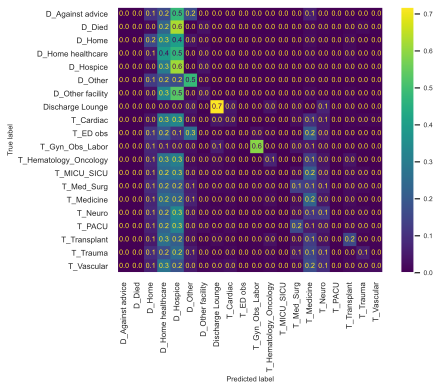

<Figure size 2000x2000 with 0 Axes>

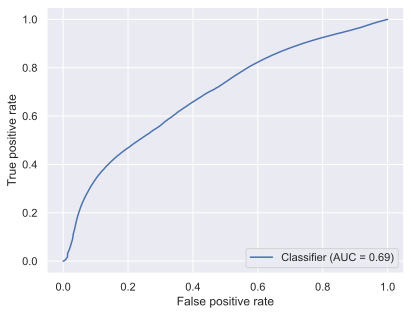

In [169]:
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed
importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_v1_1,X_test,y_test_v1,lbl_enc = le,incl_val=True)

As we see above, the model does a bad job at predicting all classes and gets particularly confused at the different discharge types. This is a good thing as we can merge these classes (our goal is predicting transfer to departments or discharge, not discharge types. Let's do this and reassess. As seen in the EDA, Discharge Lounge is an actual care unit so we will leave it separate. 

In [179]:
events_trn_v2 =  events_trn_v1.str.replace('D_Home.*|D_Other facility|D_Hospice','Discharge')
events_tst_v2 = events_tsn_v1.str.replace('D_Home.*|D_Other facility|D_Hospice','Discharge')

le_v2 = LabelEncoder()
le_v2.fit(events_trn_v2)
y_trn_v2 = le_v2.transform(events_trn_v2)
y_tst_v2 = le_v2.transform(events_tst_v2)

In [7]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = 5 

# Defining paipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

# n_range = [5,10,15]
C_range = np.logspace(1,10,num = 4) 

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

logreg_v1_2 = grid.fit(X_train_v1, y_train_v2)
display(logreg_v1_2.best_estimator_)
print(logreg_v1_2.best_score_)

dump(logreg_v1_2,'models/logreg_v1_2.joblib')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10000000.0))])

0.5688659193320894


['models/logreg_v1_2.joblib']

Best model's CV score: 0.5688659193320894
Best model's test score 0.48027291825466173
Baseline model (score of a model that always predicts majoritary class) 0.43


<Figure size 3200x2400 with 0 Axes>

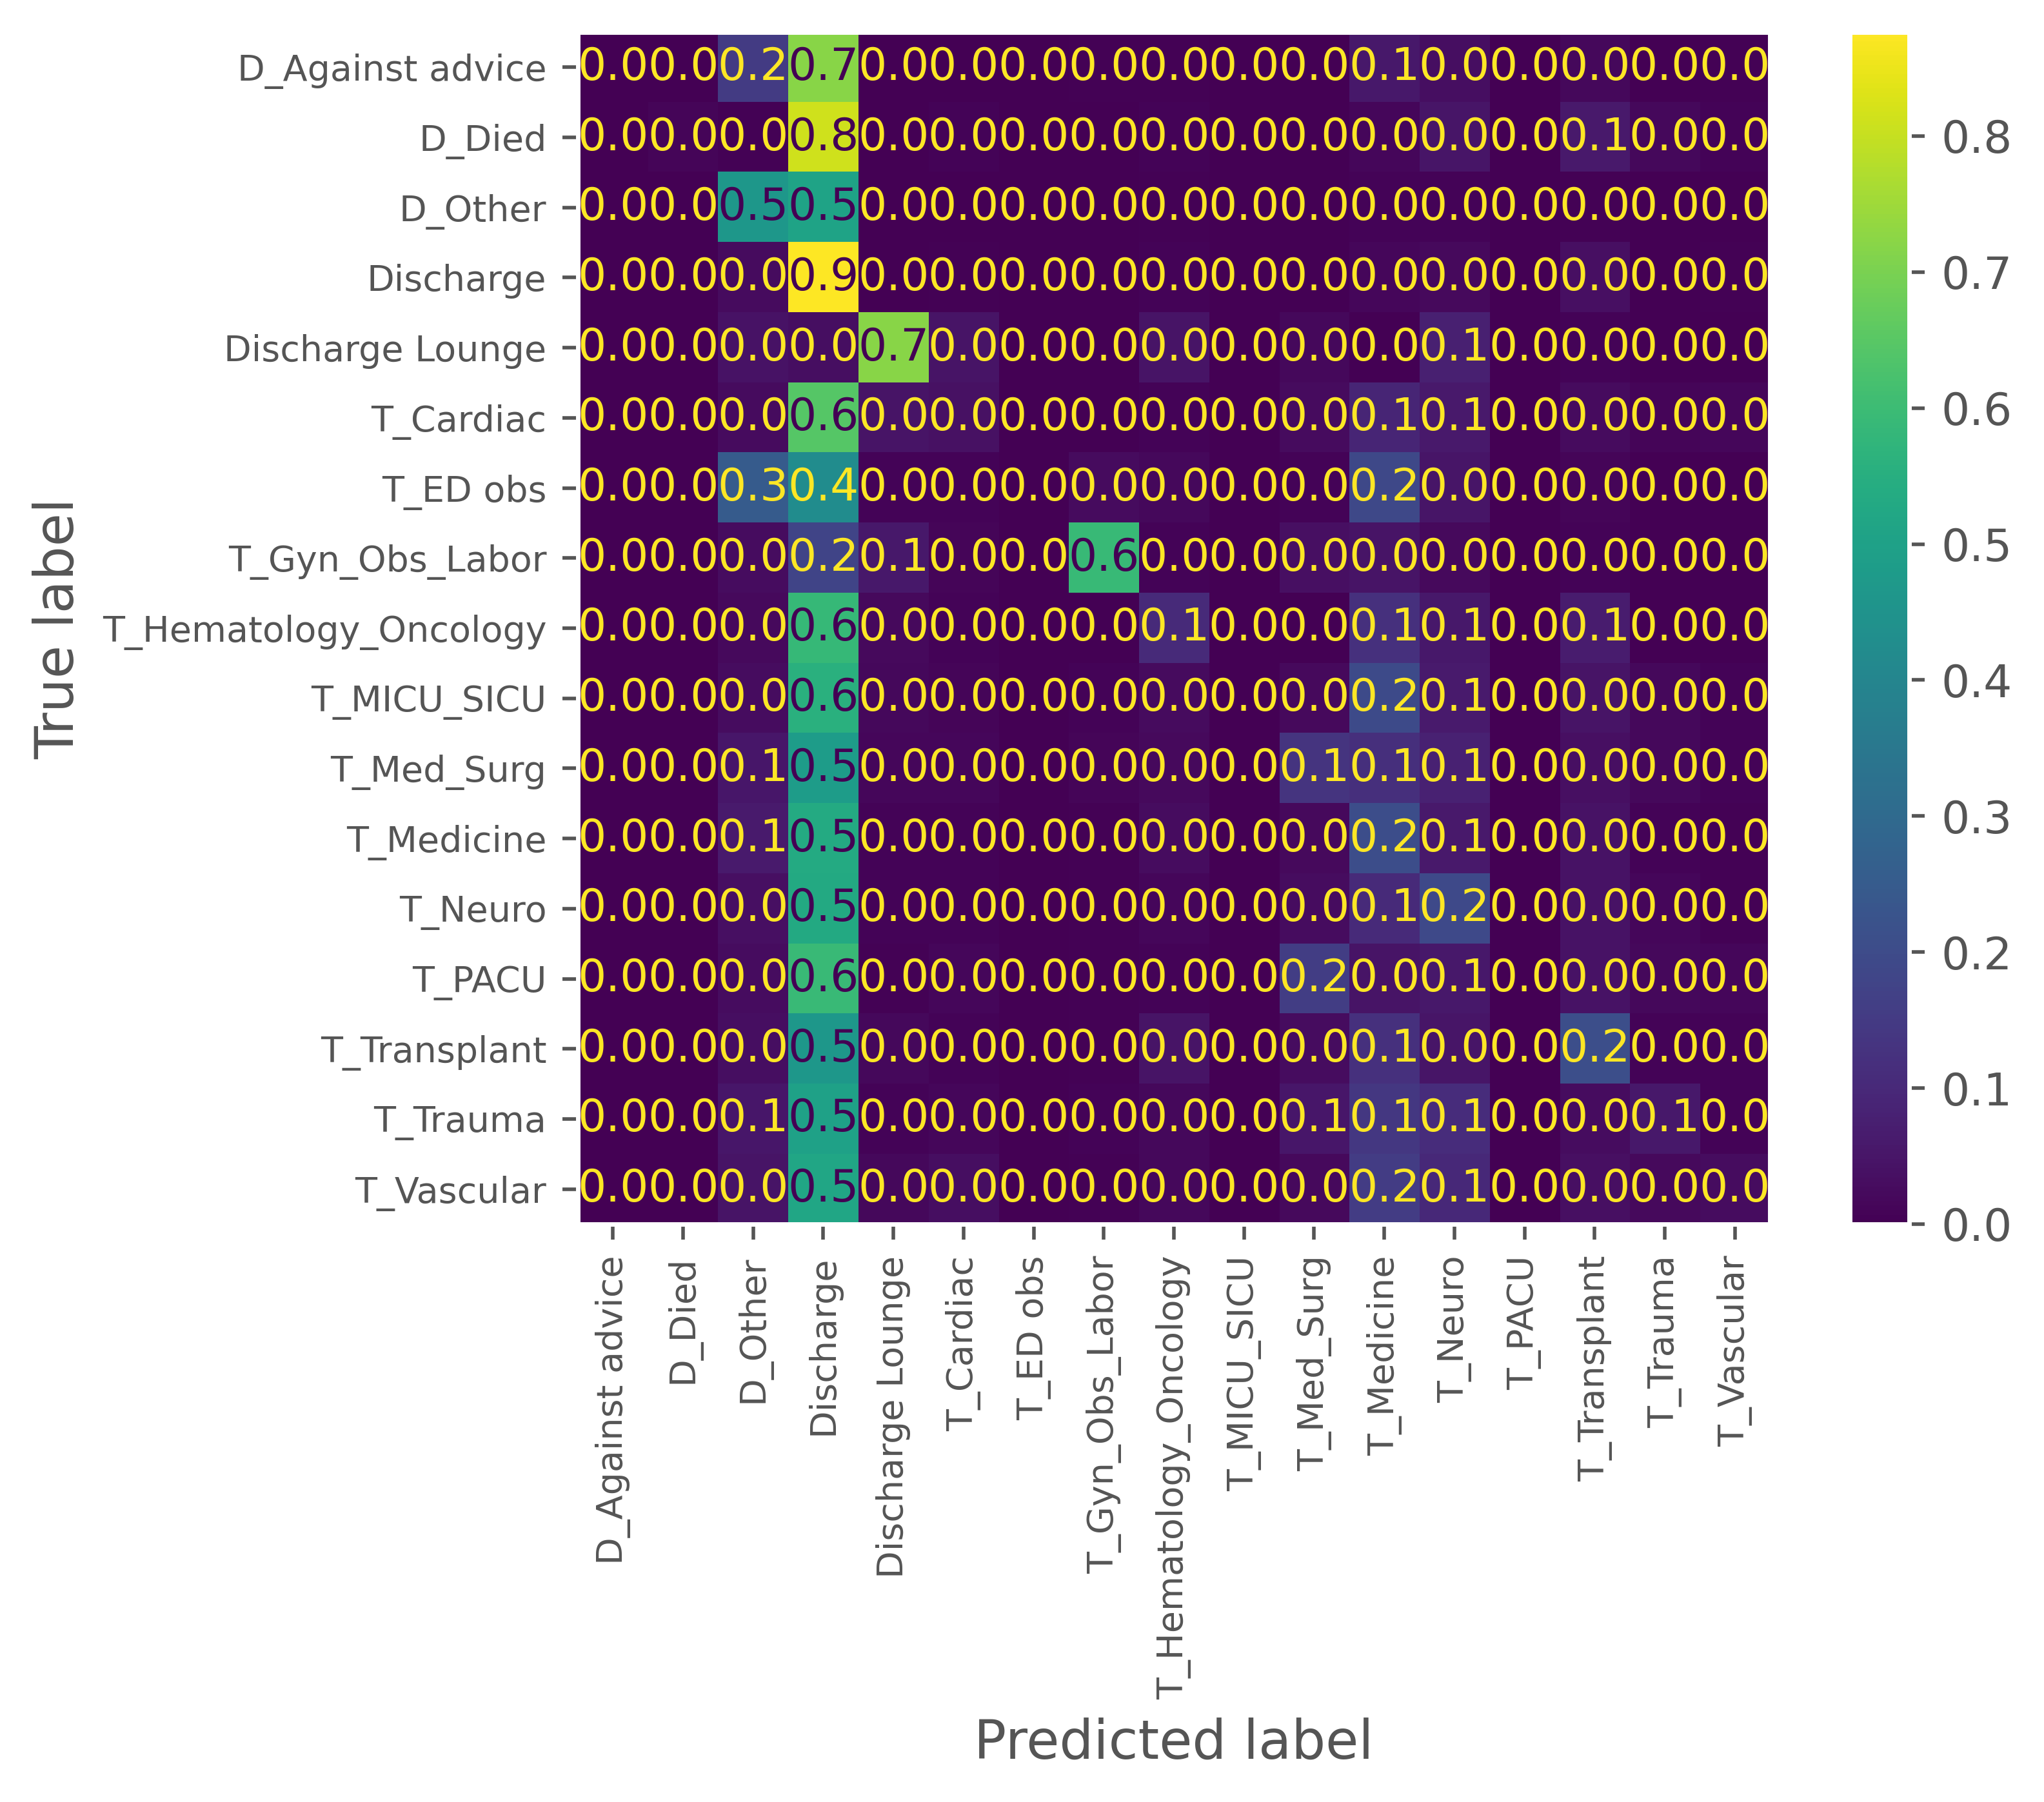

<Figure size 3200x2400 with 0 Axes>

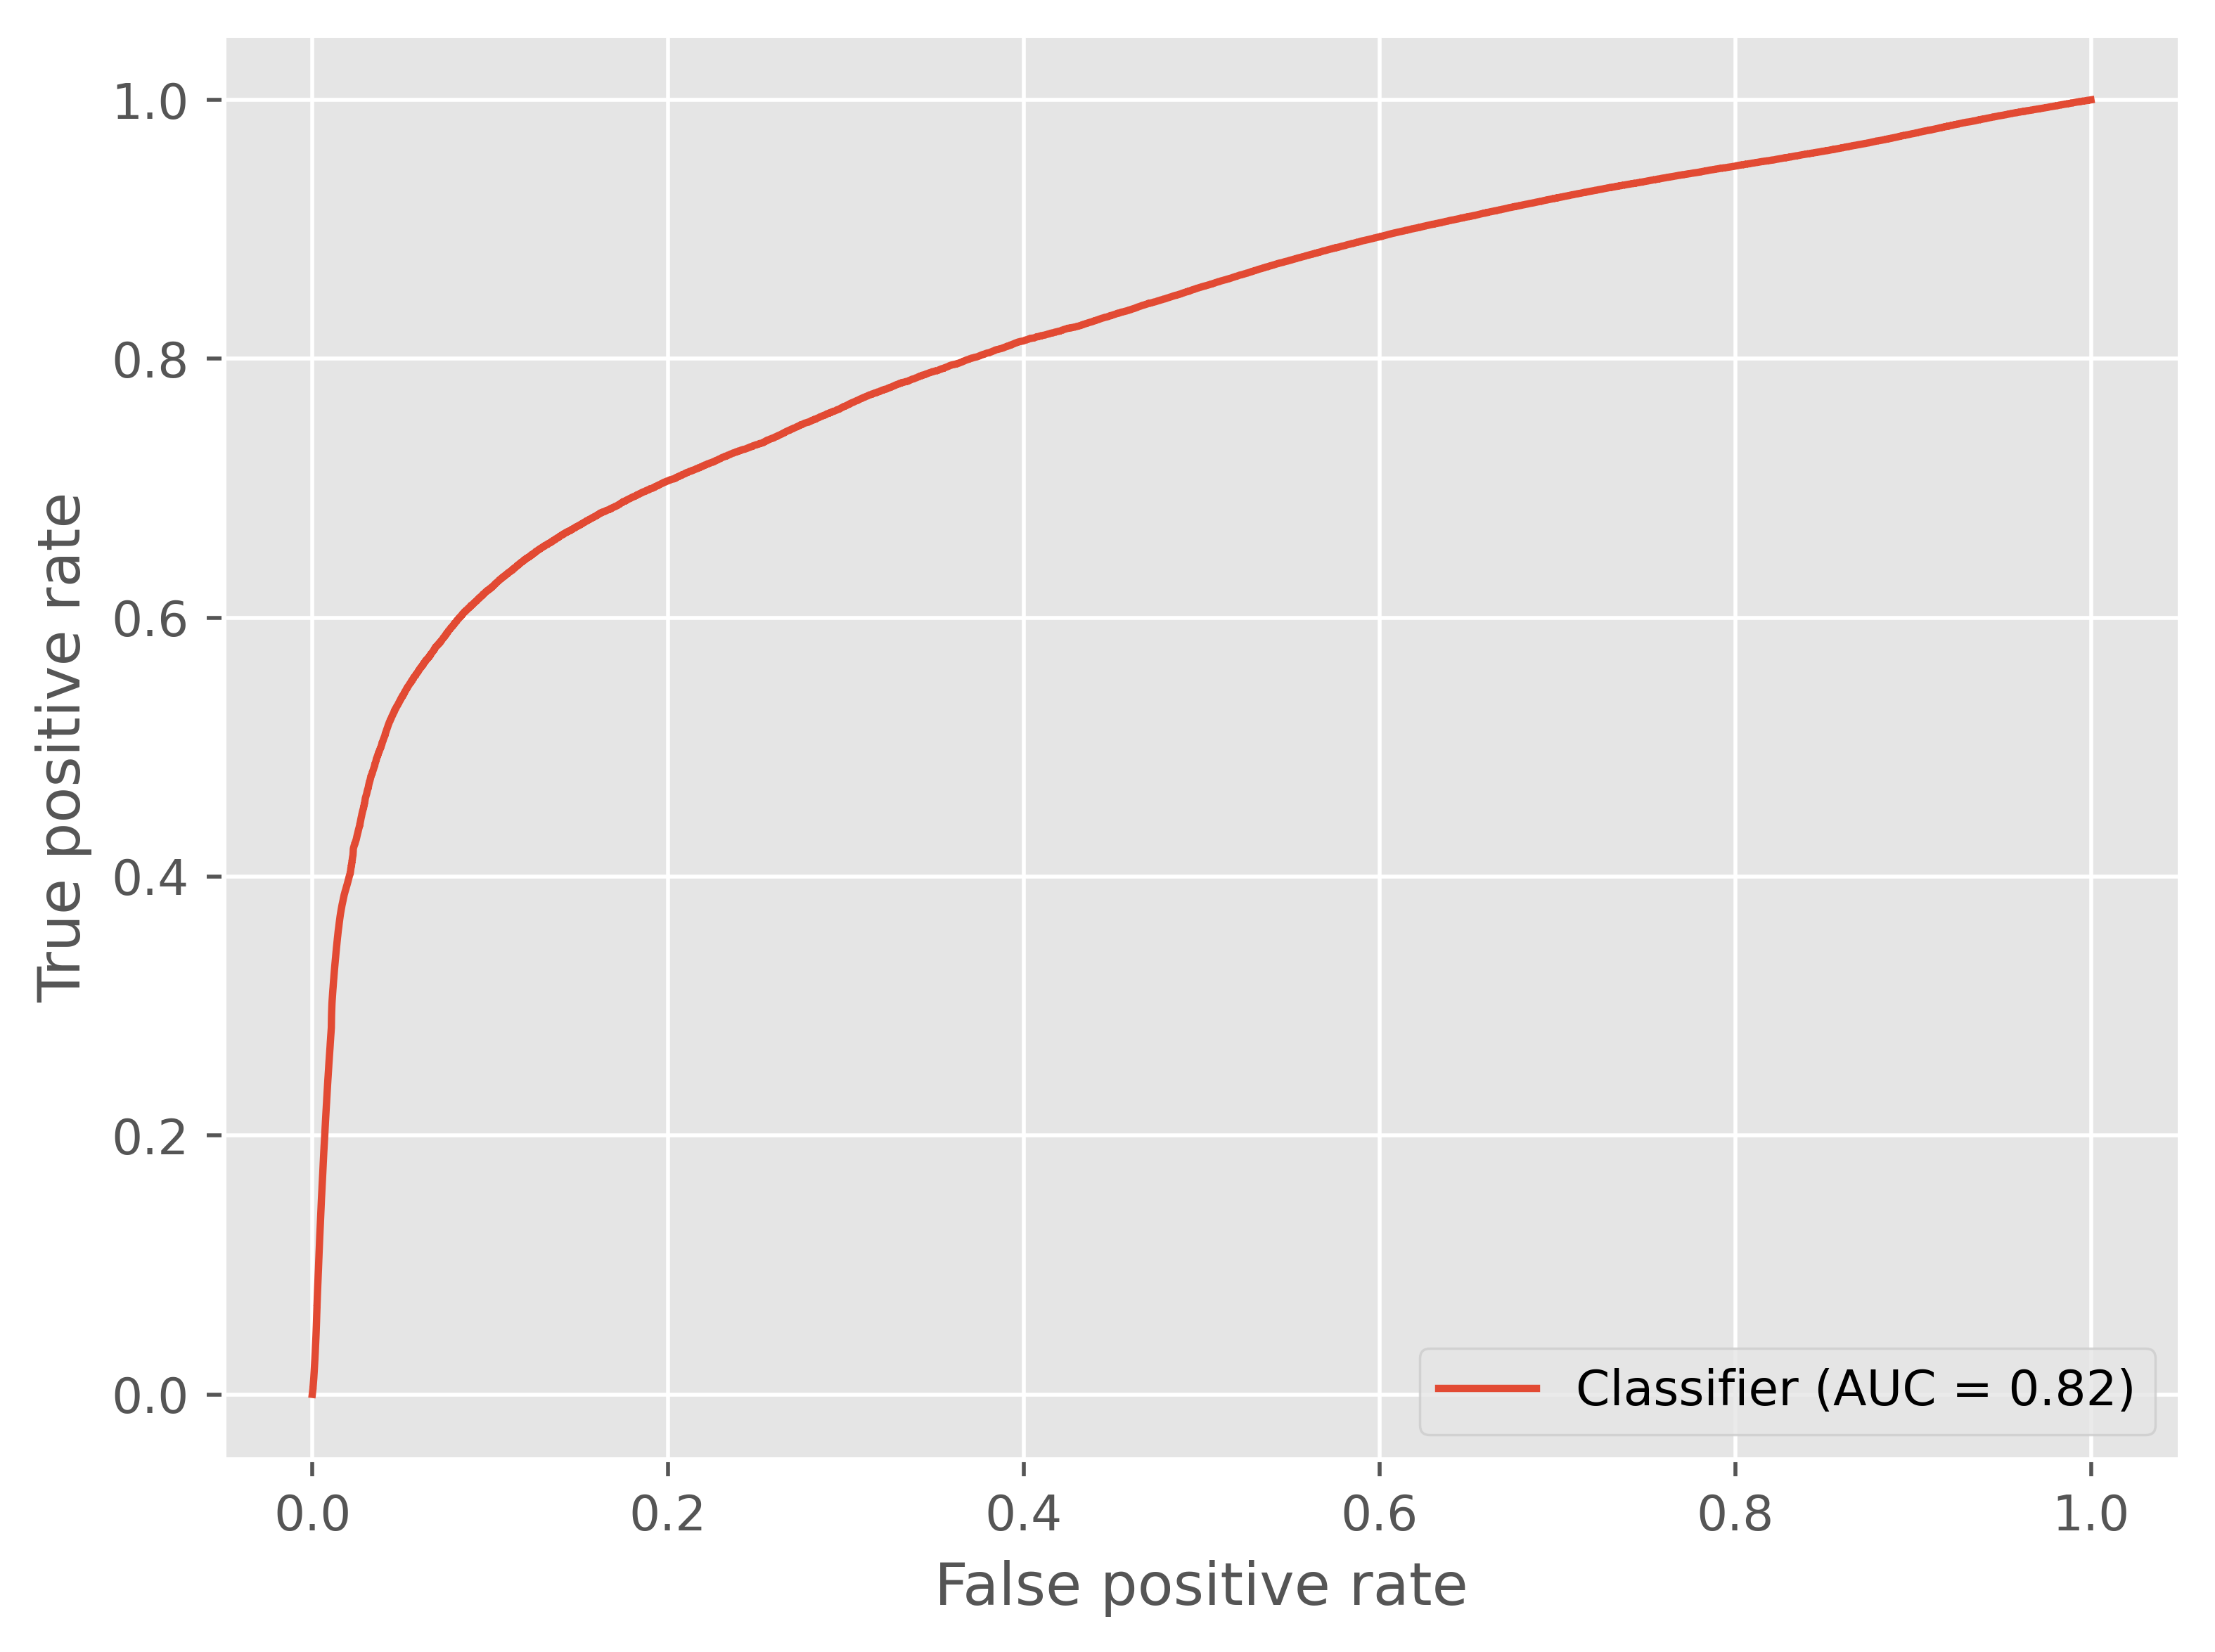

In [134]:
importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_v1_2,X_test,y_test_v2,lbl_enc = le)

That is better for the discharges, but the accuracy for the transfers is similar. We also see that the precision for class discharge is very low, because of the class imbalance. Let's re-merge the discharge classes.

In [182]:
events_trn_v3 = events_trn_v2.copy()
events_trn_v3[events_trn_v3.str.contains('D_',regex = False)] = 'Discharge'

events_tst_v3 = events_tst_v2.copy()
events_tst_v3[events_tst_v3.str.contains('D_',regex = False)] = 'Discharge'

le_v3 = LabelEncoder().fit(events_trn_v3)
y_trn_v3 = le_v3.transform(events_trn_v3)
y_tst_v3 = le_v3.transform(events_tst_v3)

Let's look first at the class imbalance again

In [183]:
events_v3.value_counts()

Discharge                311535
T_Medicine                67942
T_Cardiac                 44194
T_Med_Surg                42998
T_MICU_SICU               25893
T_Trauma                  25204
T_Neuro                   24794
T_Gyn_Obs_Labor           24673
T_Hematology_Oncology     13001
T_ED obs                  12198
T_Vascular                11487
T_Transplant              11482
T_PACU                     7186
T_Discharge Lounge         4944
Name: event, dtype: int64

Let's fix that class imbalance with some smoting followed by undersampling. We will add _res to the resampled data

In [185]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)

X_trn_v1_res, y_trn_v3_res = sm.fit_resample(X_trn_v1,y_trn_v3)

NameError: name 'y_train' is not defined

Now some undersampling

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state = 42)

X_trn_v1_res, y_trn_v3_res = cc.fit_resample(X_trn_v1_res, y_trn_v3_res)

np.unique(y_trn_v3_res, return_counts=True)

In [ ]:
X_trn_v1_res.dump('../Capstone data/pickles/X_trn_v1_res.npy')
y_trn_v3_res.dump('../Capstone data/pickles/y_trn_v3_res.npy')